Seismic Image Classification - Convolutional Neural Network
---------------------------------------------

### Load required libraries

In [1]:
# Let's import the libraries required for the image classification
import os
import glob
RAND_SEED = 12345
import numpy as np
np.random.seed(RAND_SEED)
import tensorflow as tf
tf.random.set_seed(RAND_SEED)
import random
random.seed(RAND_SEED)
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Load data from files

In [2]:
IMG_DIM = 96
IMG_PER_CLASS = 500
TEST_SPLIT_FRAC = 0.1
TRAIN_SPLIT_FRAC = 0.9
BATCH_SIZE = 32
NUM_CLASSES = 3

data_dir = './data'
class_names = ['fault', 'salt', 'other']
file_list = []

for class_name in class_names:
    class_files = glob.glob(data_dir + os.path.sep + \
                            class_name + os.path.sep + '*.png')
    for f in class_files:
        file_list.append(f)

def get_class_label(file_path):
    # Split file path to get directory and file names.
    path_split = file_path.split(os.path.sep)
    # The second-last string contains name of the class directory;
    # Use it to create class label.
    return class_names.index(path_split[-2].strip())

def decode_image(img):
    # Convert the passed image to a uint8 tensor;
    # Using 1 channel, as the images are grayscale.
    img = tf.image.decode_png(img, channels=1)
    # Convert image to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the predefined image size.
    return tf.image.resize(img, [IMG_DIM, IMG_DIM]).numpy()

def process_file_path(file_path):
    label = get_class_label(file_path)
    # Load data from the image file.
    img = tf.io.read_file(file_path)
    # Decode and convert image data to float32.
    img = decode_image(img)
    return img, label

images = []
labels = []
for f in file_list:
    img, label = process_file_path(f)
    images.append(img)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

### Create training, validation, and test data sets

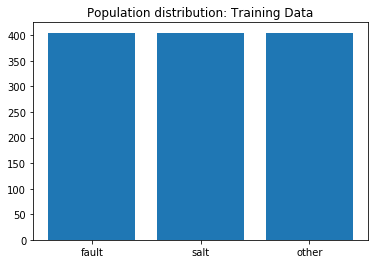

In [3]:
def split_datasets(images, labels):
    # Split data into train, validation, and test data sets.
    X_rest, X_test, y_rest, y_test = \
    train_test_split(images, labels, test_size=TEST_SPLIT_FRAC, 
                     random_state=RAND_SEED, stratify=labels)
    X_train, X_valid, y_train, y_valid = \
    train_test_split(X_rest, y_rest, train_size=TRAIN_SPLIT_FRAC, 
                     random_state=RAND_SEED, stratify=y_rest)
    return X_train, X_valid, X_test, y_train, y_valid, y_test
    
X_train, X_valid, X_test, y_train, y_valid, y_test = \
split_datasets(images, labels)

# Plot class population distribution in the training data
# Calculate population of three classes
population = [len(np.where(y_train == 0)[0]), 
              len(np.where(y_train == 1)[0]),
              len(np.where(y_train == 2)[0])]
# Plot
plt.bar(class_names, population)
plt.title('Population distribution: Training Data')

# determine the number of input features
n_train = population[0] + population[1] + population[2]
n_test = int(NUM_CLASSES * IMG_PER_CLASS * TEST_SPLIT_FRAC)
n_valid = NUM_CLASSES * IMG_PER_CLASS - n_train - n_test
X_train = np.reshape(X_train, (n_train, IMG_DIM, IMG_DIM, 1))
X_valid = np.reshape(X_valid, (n_valid, IMG_DIM, IMG_DIM, 1))
X_test = np.reshape(X_test, (n_test, IMG_DIM, IMG_DIM, 1))

### Visualize Training Images

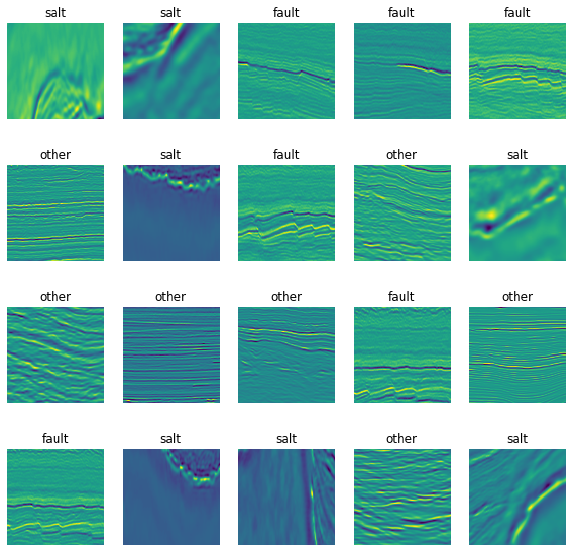

In [4]:
def show_training_images(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(X_train[i].reshape(IMG_DIM, IMG_DIM))
        plt.title(class_names[y_train[i]])
        plt.axis('off')

show_training_images(X_train, y_train)

### Build and train a Deep Neural Network model

In [5]:
# Define a Deep Neural Network model
model = Sequential()
model.add(Conv2D(96, (5, 5), activation='relu', 
                 input_shape=(IMG_DIM, IMG_DIM, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

# compile the model
model.compile(optimizer='Adadelta', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Early-stopping callback using validation
earlystop_callback = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001,
    patience=50)
# Save the best model
ckpt_path = './models/cnn.h5'
ckpt_callback = ModelCheckpoint(filepath=ckpt_path, mode='max', 
                                monitor='val_accuracy', verbose=1, 
                                save_best_only=True)
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[earlystop_callback, ckpt_callback], 
                    verbose=1)

Train on 1215 samples, validate on 135 samples
Epoch 1/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0983 - accuracy: 0.3328
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to ./models/cnn.h5
1215/1215 [==============================] - 108s 89ms/sample - loss: 1.0983 - accuracy: 0.3333 - val_loss: 1.0978 - val_accuracy: 0.3333
Epoch 2/500
1184/1215 [============================>.] - ETA: 1s - loss: 1.0978 - accuracy: 0.3294
Epoch 00002: val_accuracy did not improve from 0.33333
1215/1215 [==============================] - 74s 61ms/sample - loss: 1.0976 - accuracy: 0.3333 - val_loss: 1.0972 - val_accuracy: 0.3333
Epoch 3/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0971 - accuracy: 0.3336
Epoch 00003: val_accuracy did not improve from 0.33333
1215/1215 [==============================] - 108s 89ms/sample - loss: 1.0971 - accuracy: 0.3333 - val_loss: 1.0967 - val_accuracy: 0.3333
Epoch 4/500
1184/1215 [=====================

Epoch 29/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0895 - accuracy: 0.3539
Epoch 00029: val_accuracy improved from 0.34074 to 0.36296, saving model to ./models/cnn.h5
1215/1215 [==============================] - 93s 76ms/sample - loss: 1.0894 - accuracy: 0.3572 - val_loss: 1.0883 - val_accuracy: 0.3630
Epoch 30/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0888 - accuracy: 0.3851
Epoch 00030: val_accuracy did not improve from 0.36296
1215/1215 [==============================] - 105s 86ms/sample - loss: 1.0892 - accuracy: 0.3819 - val_loss: 1.0880 - val_accuracy: 0.3630
Epoch 31/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0887 - accuracy: 0.3834
Epoch 00031: val_accuracy did not improve from 0.36296
1215/1215 [==============================] - 103s 85ms/sample - loss: 1.0889 - accuracy: 0.3819 - val_loss: 1.0878 - val_accuracy: 0.3630
Epoch 32/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0893 - ac

Epoch 57/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0783 - accuracy: 0.4552
Epoch 00057: val_accuracy did not improve from 0.48148
1215/1215 [==============================] - 97s 80ms/sample - loss: 1.0787 - accuracy: 0.4519 - val_loss: 1.0768 - val_accuracy: 0.4296
Epoch 58/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0785 - accuracy: 0.4578
Epoch 00058: val_accuracy did not improve from 0.48148
1215/1215 [==============================] - 100s 82ms/sample - loss: 1.0782 - accuracy: 0.4601 - val_loss: 1.0762 - val_accuracy: 0.4222
Epoch 59/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0781 - accuracy: 0.4088
Epoch 00059: val_accuracy did not improve from 0.48148
1215/1215 [==============================] - 90s 74ms/sample - loss: 1.0777 - accuracy: 0.4132 - val_loss: 1.0756 - val_accuracy: 0.4444
Epoch 60/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0773 - accuracy: 0.4603
Epoch 00060: val_accura

Epoch 85/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0577 - accuracy: 0.4975
Epoch 00085: val_accuracy did not improve from 0.48889
1215/1215 [==============================] - 95s 78ms/sample - loss: 1.0583 - accuracy: 0.4914 - val_loss: 1.0549 - val_accuracy: 0.4444
Epoch 86/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0573 - accuracy: 0.4856
Epoch 00086: val_accuracy did not improve from 0.48889
1215/1215 [==============================] - 105s 87ms/sample - loss: 1.0573 - accuracy: 0.4856 - val_loss: 1.0537 - val_accuracy: 0.4444
Epoch 87/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0558 - accuracy: 0.5000
Epoch 00087: val_accuracy did not improve from 0.48889
1215/1215 [==============================] - 101s 83ms/sample - loss: 1.0561 - accuracy: 0.4979 - val_loss: 1.0525 - val_accuracy: 0.4444
Epoch 88/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0550 - accuracy: 0.4941
Epoch 00088: val_accur

Epoch 113/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0100 - accuracy: 0.5169
Epoch 00113: val_accuracy did not improve from 0.55556
1215/1215 [==============================] - 105s 86ms/sample - loss: 1.0101 - accuracy: 0.5193 - val_loss: 1.0038 - val_accuracy: 0.4963
Epoch 114/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0064 - accuracy: 0.5338
Epoch 00114: val_accuracy did not improve from 0.55556
1215/1215 [==============================] - 103s 85ms/sample - loss: 1.0074 - accuracy: 0.5292 - val_loss: 1.0013 - val_accuracy: 0.4519
Epoch 115/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0038 - accuracy: 0.5228
Epoch 00115: val_accuracy did not improve from 0.55556
1215/1215 [==============================] - 109s 90ms/sample - loss: 1.0045 - accuracy: 0.5218 - val_loss: 0.9980 - val_accuracy: 0.4889
Epoch 116/500
1184/1215 [============================>.] - ETA: 2s - loss: 1.0006 - accuracy: 0.5372
Epoch 00116: val_

1184/1215 [============================>.] - ETA: 1s - loss: 0.6659 - accuracy: 0.8252
Epoch 00167: val_accuracy did not improve from 0.82963
1215/1215 [==============================] - 58s 47ms/sample - loss: 0.6672 - accuracy: 0.8222 - val_loss: 0.6502 - val_accuracy: 0.8296
Epoch 168/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.6591 - accuracy: 0.8193
Epoch 00168: val_accuracy did not improve from 0.82963
1215/1215 [==============================] - 55s 45ms/sample - loss: 0.6598 - accuracy: 0.8206 - val_loss: 0.6437 - val_accuracy: 0.8296
Epoch 169/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.6520 - accuracy: 0.8235
Epoch 00169: val_accuracy improved from 0.82963 to 0.85185, saving model to ./models/cnn.h5
1215/1215 [==============================] - 55s 45ms/sample - loss: 0.6515 - accuracy: 0.8255 - val_loss: 0.6324 - val_accuracy: 0.8519
Epoch 170/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.6433 - accuracy: 0.82

Epoch 195/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.4869 - accuracy: 0.8522
Epoch 00195: val_accuracy did not improve from 0.88148
1215/1215 [==============================] - 55s 45ms/sample - loss: 0.4863 - accuracy: 0.8527 - val_loss: 0.4630 - val_accuracy: 0.8815
Epoch 196/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.4781 - accuracy: 0.8547
Epoch 00196: val_accuracy did not improve from 0.88148
1215/1215 [==============================] - 54s 45ms/sample - loss: 0.4812 - accuracy: 0.8527 - val_loss: 0.4611 - val_accuracy: 0.8667
Epoch 197/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.4752 - accuracy: 0.8530
Epoch 00197: val_accuracy did not improve from 0.88148
1215/1215 [==============================] - 54s 44ms/sample - loss: 0.4757 - accuracy: 0.8519 - val_loss: 0.4599 - val_accuracy: 0.8519
Epoch 198/500
1184/1215 [============================>.] - ETA: 1s - loss: 0.4715 - accuracy: 0.8539
Epoch 00198: val_acc

### Review the model training

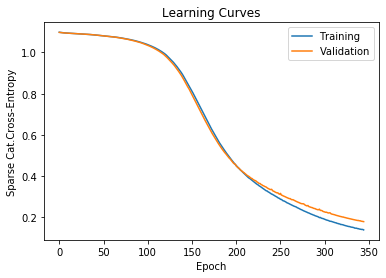

In [6]:
# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Sparse Cat.Cross-Entropy')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

### Use saved model to predict test data

In [7]:
# Evaluate the best model using test data
model = load_model(ckpt_path)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.953
